## 0. IMPORTS

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as GridSpec
import matplotlib
import inflection
import math
import datetime
from IPython.display import Image
from tabulate import tabulate
from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [5]:
# configuração do tamanho das figuras plotadas
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

### 0.1 HELPER FUNCTIONS

In [146]:
def cramer_v(x,y):
    cm = pd.crosstab( x, y ).to_numpy()
    #cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n)/(min(kcorr-1,rcorr-1)))

def mean_absolute_percentage_error (y, yhat):
   return np.mean(np.abs(( y - yhat )/y))


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error (y, yhat)
    mape = mean_absolute_percentage_error (y, yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame ({'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0])

def cross_validation (x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range(1,kfold+1) ):
        if verbose:
            print( '\nKFold_Number: {}'.format(k) )

        # start and end date for validatiton
        validation_start_date = x_training['date'].max() - datetime.timedelta( days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date ]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining,ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error( model_name, np.expm1(yvalidation), np.expm1(yhat) )
        #print(m_result)

        # store performance for each kfold interation
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame( {'Model name' : model_name,
                          'MAE CV' : np.round( np.mean ( mae_list ), 2 ).astype(str) + '+/-' + np.round( np.std ( mae_list ), 2 ).astype(str),
                          'MAPE CV' : np.round( np.mean ( mape_list ), 2 ).astype(str) + '+/-' + np.round( np.std ( mape_list ), 2 ).astype(str),
                          'RMSE CV' : np.round( np.mean ( rmse_list ), 2 ).astype(str) + '+/-' + np.round( np.std ( rmse_list ), 2 ).astype(str)}, index=[0])

In [7]:
df_sales_raw = pd.read_csv("data/train.csv", low_memory=False)
df_store_raw = pd.read_csv("data/store.csv", low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

## 1. DESCRIÇÃO DOS DADOS

In [8]:
df1 = df_raw.copy()

### 1.1 RENAME COLUMNS

In [9]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
                'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
               'CompetitionDistance', 'CompetitionOpenSinceMonth',
               'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
               'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,cols_old))

# rename
df1.columns = cols_new

### 1.2 DATA DIMENTIONS

In [10]:
print('Number of raws: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of raws: 1017209
Number of columns: 18


### 1.3 DATA TYPES

In [11]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4 CHECK NA

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5 FILLOUT NA

In [13]:
#competition_distance
# colocar uma distancia muito maior que a distancia máxima seria o mesmo que dizer que não existe competidor mais próximo
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df1['promo_interval'].fillna(0,inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['month_map','promo_interval']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

### 1.6 CHANGE TYPES

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

### 1.7 DESCRIPTIVE STATISTICAL

In [15]:
num_attributes = df1.select_dtypes(include=['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'int32', 'float64', 'datetime64[ns]'])

#### 1.7.1 NUMERICAL ATTRIBUTES

In [16]:
# Central tendency - mean, midian
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [17]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\re91107z\AppData\Local\Continuum\anaconda3\envs\Repositorio\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

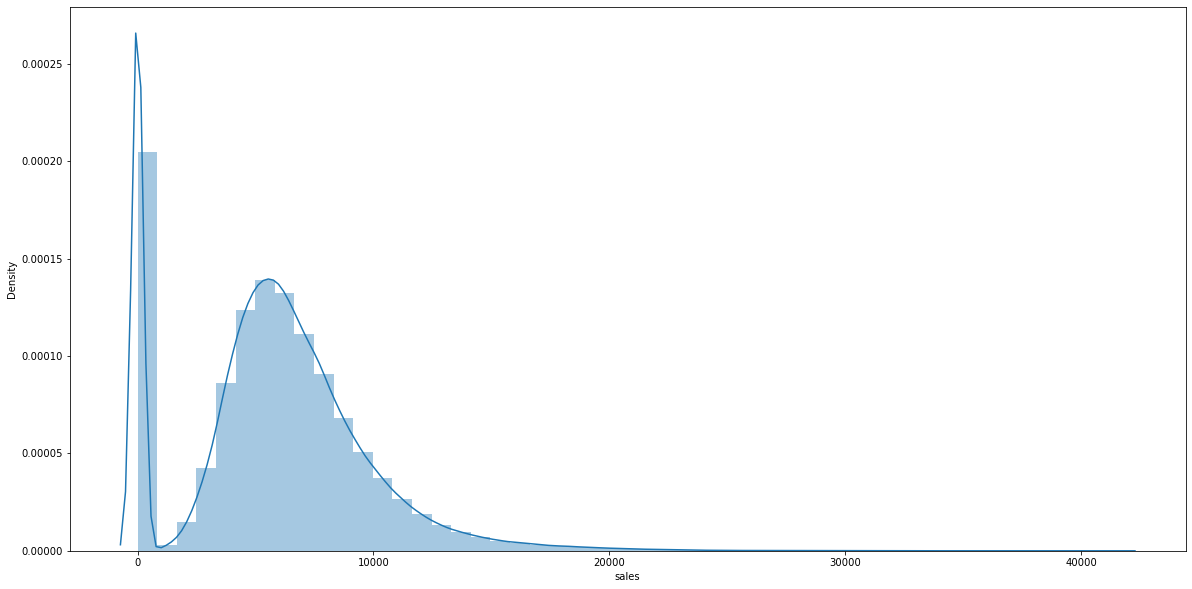

In [18]:
sns.distplot(df1['sales'])

C:\Users\re91107z\AppData\Local\Continuum\anaconda3\envs\Repositorio\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

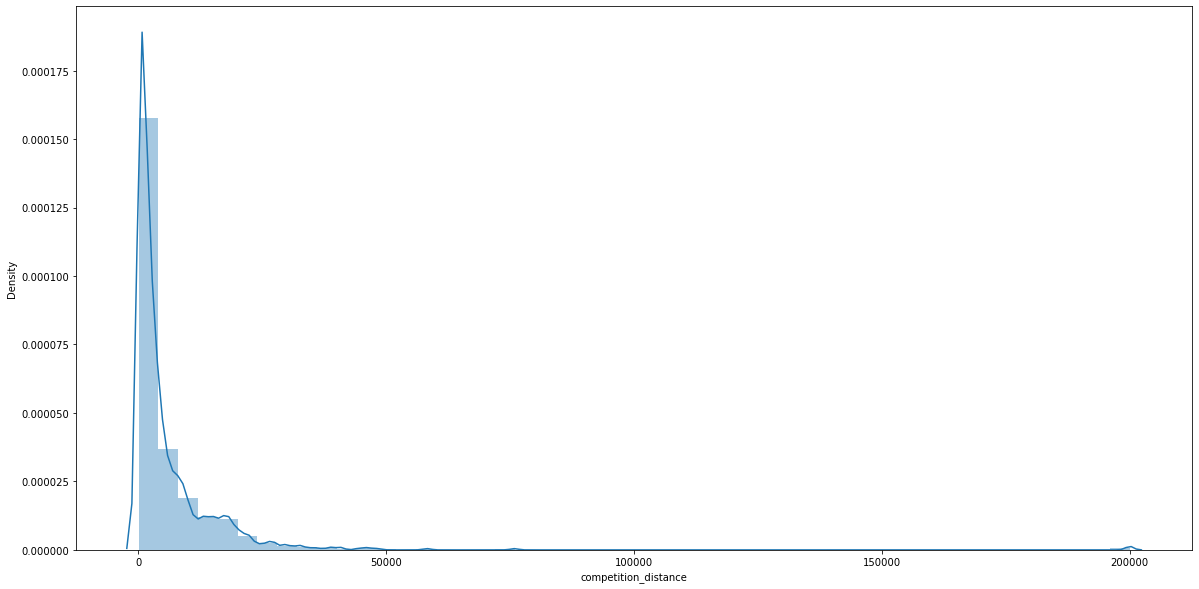

In [19]:
sns.distplot(df1['competition_distance'])

#### 1.7.2 CATEGORICAL ATTRIBUTES

In [20]:
cat_attributes.apply(lambda x: x.unique())

state_holiday                                          [0, a, b, c]
store_type                                             [c, a, d, b]
assortment                                                [a, c, b]
promo_interval    [0, Jan,Apr,Jul,Oct, Feb,May,Aug,Nov, Mar,Jun,...
month_map         [Jul, Jun, May, Apr, Mar, Fev, Jan, Dec, Nov, ...
dtype: object

In [21]:
cat_attributes.apply(lambda x: x.unique().shape[0])
#cat_attributes.apply(lambda x: x.nunique())

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

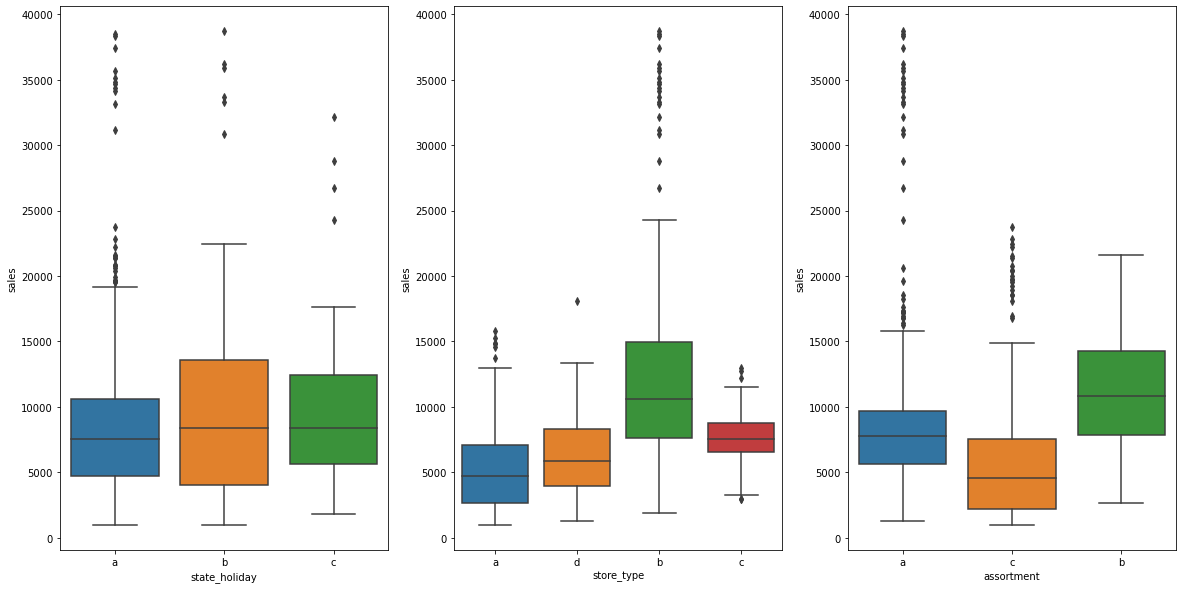

In [22]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)

# 2. FEATURE ENGINEERING

In [23]:
df2 = df1.copy()

In [24]:
Image('C:/PythonFundamentos/Estudos/Rossmann/IMG/DAILY_STORE_SALES.png')

FileNotFoundError: No such file or directory: 'C:/PythonFundamentos/Estudos/Rossmann/IMG/DAILY_STORE_SALES.png'

FileNotFoundError: No such file or directory: 'C:/PythonFundamentos/Estudos/Rossmann/IMG/DAILY_STORE_SALES.png'

<IPython.core.display.Image object>

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses Loja

**1** Lojas com número maior de funcionários deveriam vender mais

**2** Lojas com maior capacidade de estoque deveriam vender mais

**3** Lojas com maior porte deveriam vender mais

**4** Lojas com maior sortimento deveriam vender mais

**5** Lojas com competidores mais próximos deveriam vender menos

**6** Lojas com competidores a mais tempo deveriam vender mais

### 2.2.2 Hipóteses Produto

**1** Lojas que investem mais em Marketing deveriam vender mais

**2** Lojas com maior exposição de produtos deveriam vender mais

**3** Lojas com produtos com preço menor deveriam deveriam vender mais

**4** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais

**5** Lojas com promoções ativas por mais tempo deveriam vender mais

**6** Lojas com mais dias de promoção deveriam vender mais

**7** Lojas com mais promoções consecutivas deveriam vender mais

### 2.2.3 Hipóteses Tempo

**1** Lojas abertas durante o feriado de Natal deveriam vender mais

**2** Lojas deveriam vender mais ao longo dos anos

**3** Lojas deveriam vender mais no segundo semestre do ano

**4** Lojas deveriam vender mais depois do dia 10 de cada mês

**5** Lojas deveriam vender menos aos finais de semana

**6** Lojas deveriam vender menos durante os feriados escolares

## 2.3 Lista final de Hipóteses

**1** Lojas com maior sortimento deveriam vender mais

**2** Lojas com competidores mais próximos deveriam vender menos

**3** Lojas com competidores a mais tempo deveriam vender mais

**4** Lojas com promoções ativas por mais tempo deveriam vender mais

**5** Lojas com mais dias de promoção deveriam vender mais

**6** Lojas com mais promoções consecutivas deveriam vender mais

**7** Lojas abertas durante o feriado de Natal deveriam vender mais

**8** Lojas deveriam vender mais ao longo dos anos

**9** Lojas deveriam vender mais no segundo semestre do ano

**10** Lojas deveriam vender mais depois do dia 10 de cada mês

**11** Lojas deveriam vender menos aos finais de semana

**12** Lojas deveriam vender menos durante os feriados escolares

## 2.4 Feature Engeneering

In [25]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1),axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')


C:\Users\re91107z\AppData\Local\Continuum\anaconda3\envs\Repositorio\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


# 3. FILTRAGEM DE VARIÁVEIS

In [26]:
df3=df2.copy()

## 3.1 Filtragem das Linhas

In [27]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0 ) ]

## 3.2 Seleção das Colunas

In [28]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4. ANÁLISE EXPLORATÓRIA DOS DADOS

In [29]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Response Variable

C:\Users\re91107z\AppData\Local\Continuum\anaconda3\envs\Repositorio\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

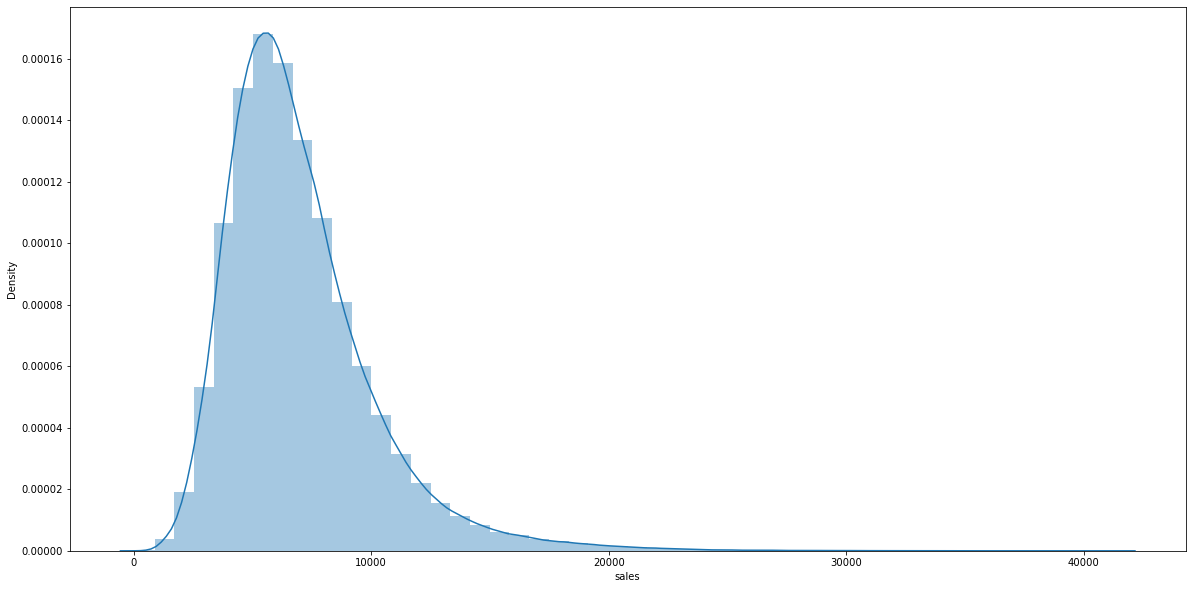

In [30]:
sns.distplot(df4['sales'])

C:\Users\re91107z\AppData\Local\Continuum\anaconda3\envs\Repositorio\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales'>

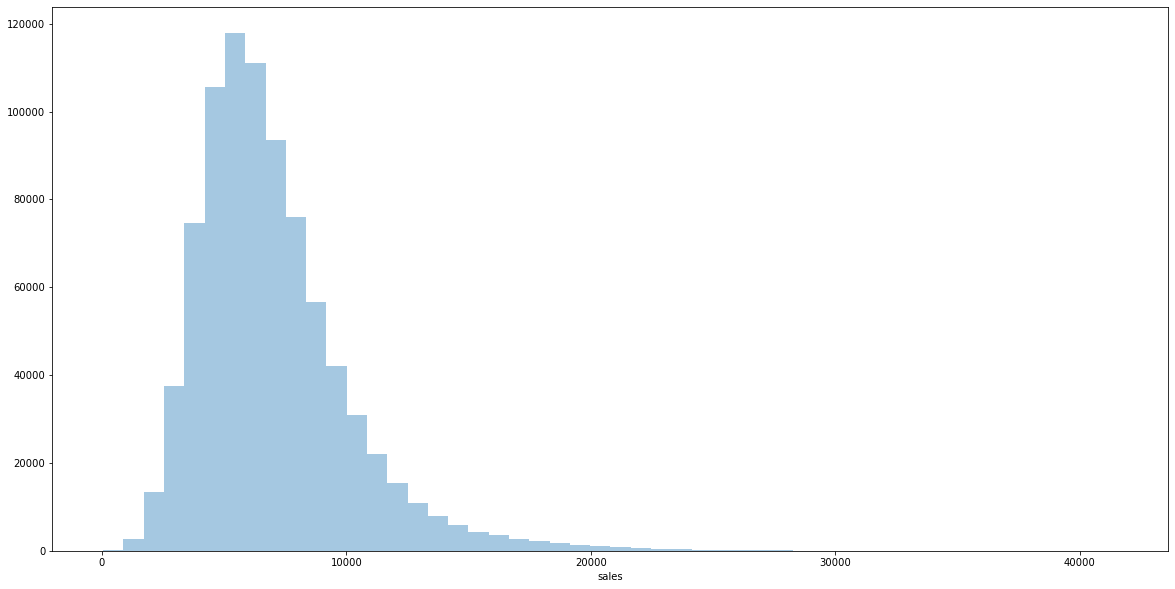

In [31]:
# Histograma
sns.distplot(df4['sales'], kde=False)

<AxesSubplot:xlabel='sales', ylabel='Density'>

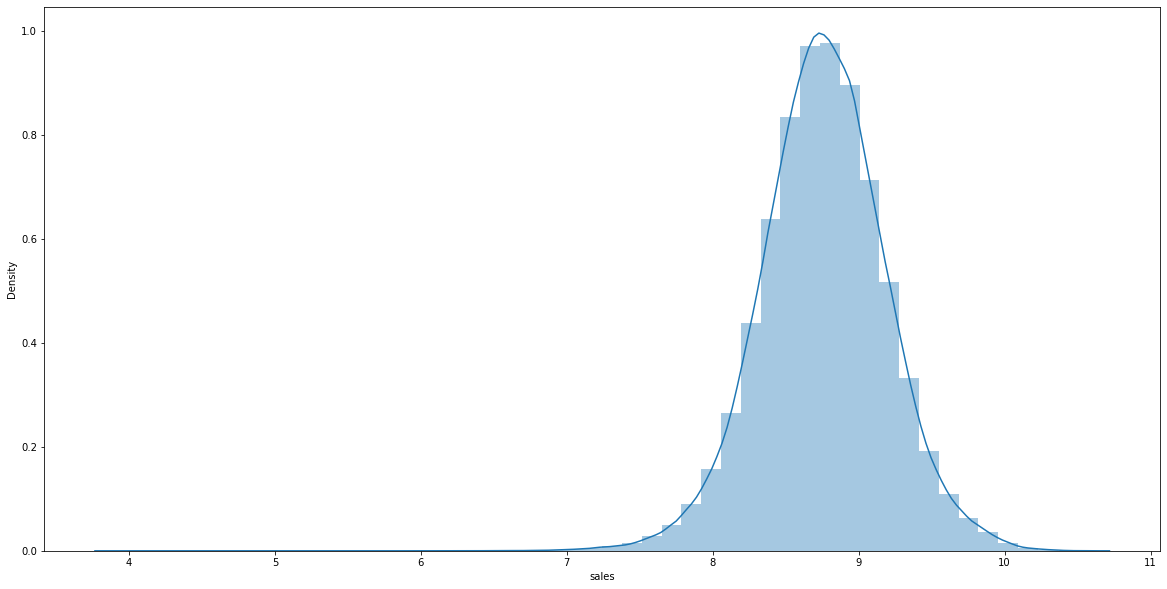

In [32]:
# Possivel transformação a ser aplicada para deixar a variavel resposta mais próxima de uma normal
# Este comportamento é desejado pois alguns algoritmos de ML performam melhor com este comportamento
sns.distplot(np.log1p(df4['sales']))

### 4.1.2 Numerical Variable

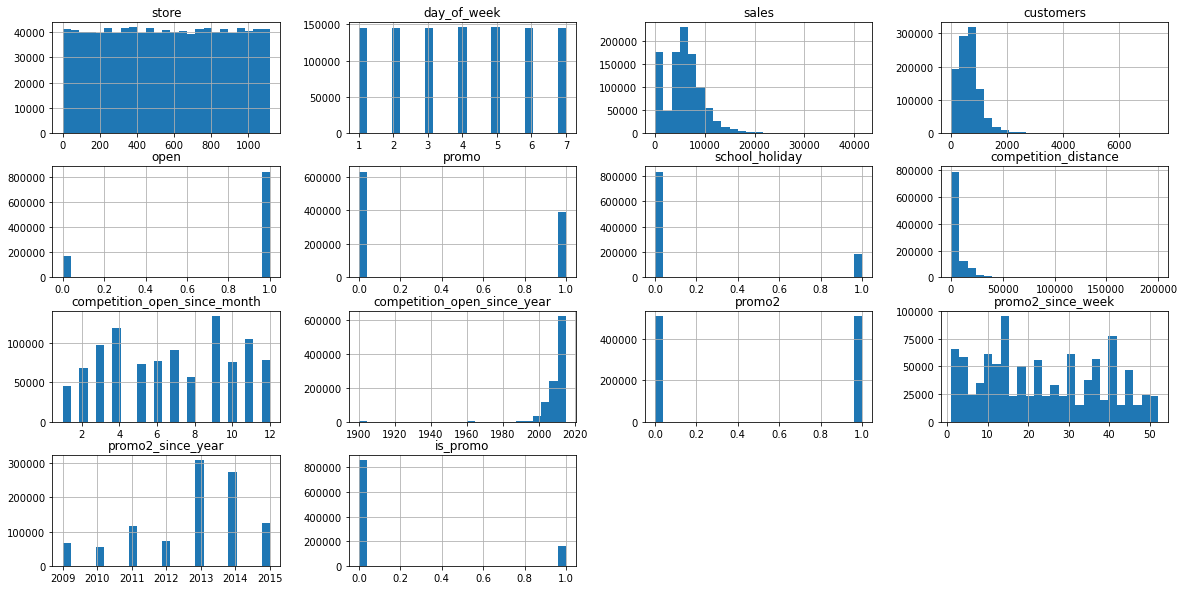

In [33]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

In [34]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [35]:
#df4['state_holiday'].drop_duplicates()
#df4['store_type'].drop_duplicates()
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

C:\Users\re91107z\AppData\Local\Continuum\anaconda3\envs\Repositorio\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\re91107z\AppData\Local\Continuum\anaconda3\envs\Repositorio\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\re91107z\AppData\Local\Continuum\anaconda3\envs\Repositorio\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other ar

<AxesSubplot:xlabel='sales', ylabel='Density'>

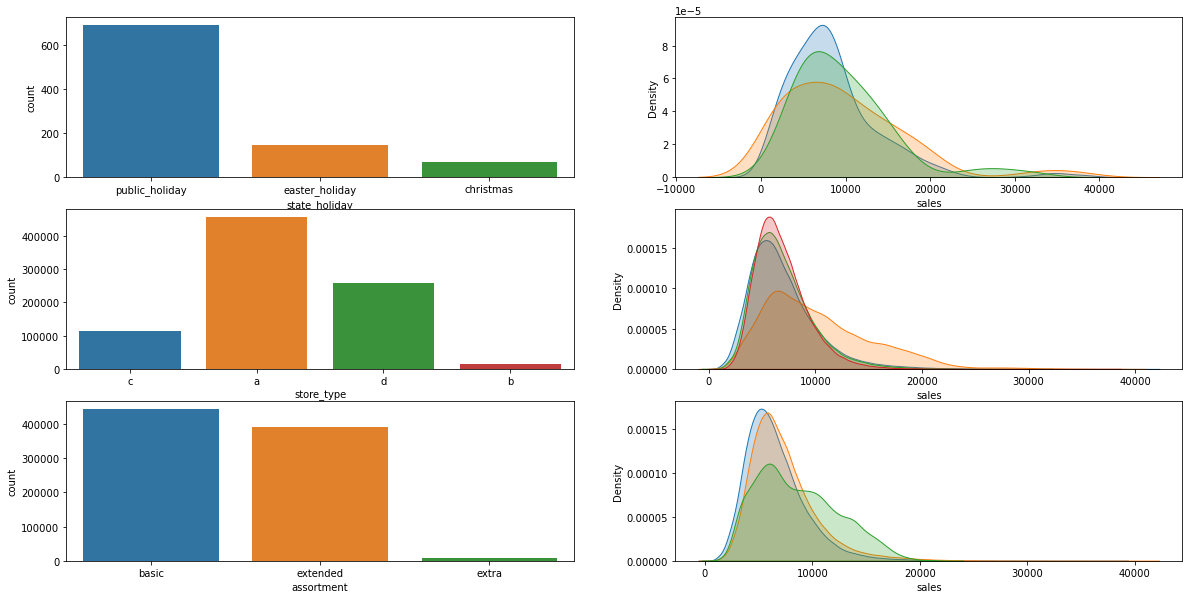

In [36]:
# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'], label='christmas', shade=True)

# store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type']=='b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type']=='c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type']=='d']['sales'], label='d', shade=True)

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment']=='extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment']=='extra']['sales'], label='extra', shade=True)


## 4.2 Analise Bivariada

### **H1** Lojas com maior sortimento deveriam vender mais
**FALSA** Lojas com MAIOR SORTIMENTO vendem menos

<AxesSubplot:xlabel='year_week'>

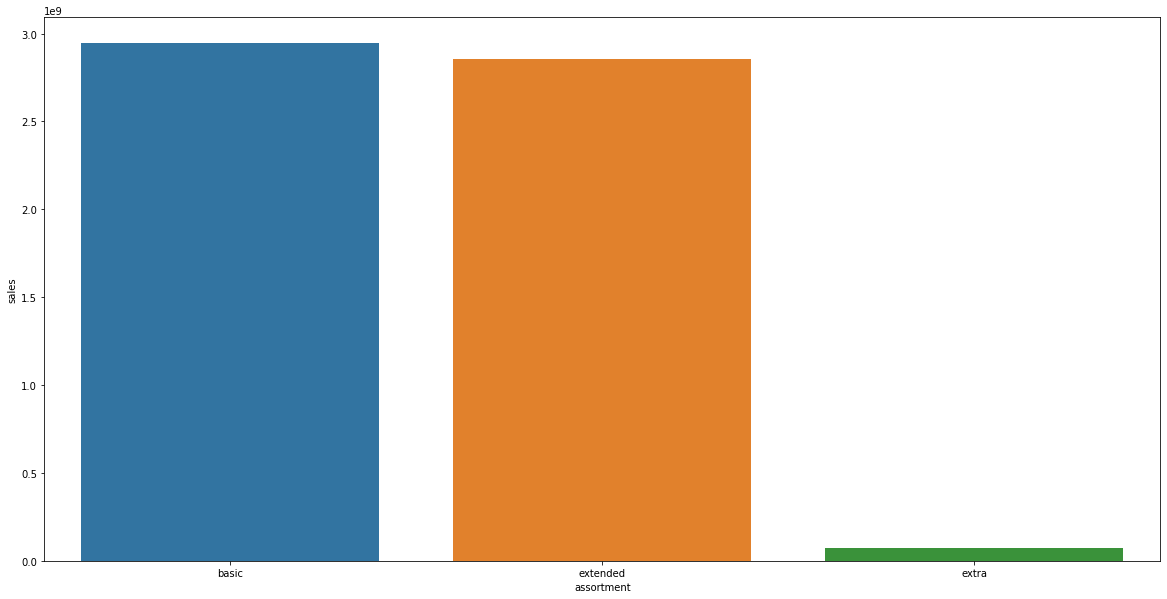

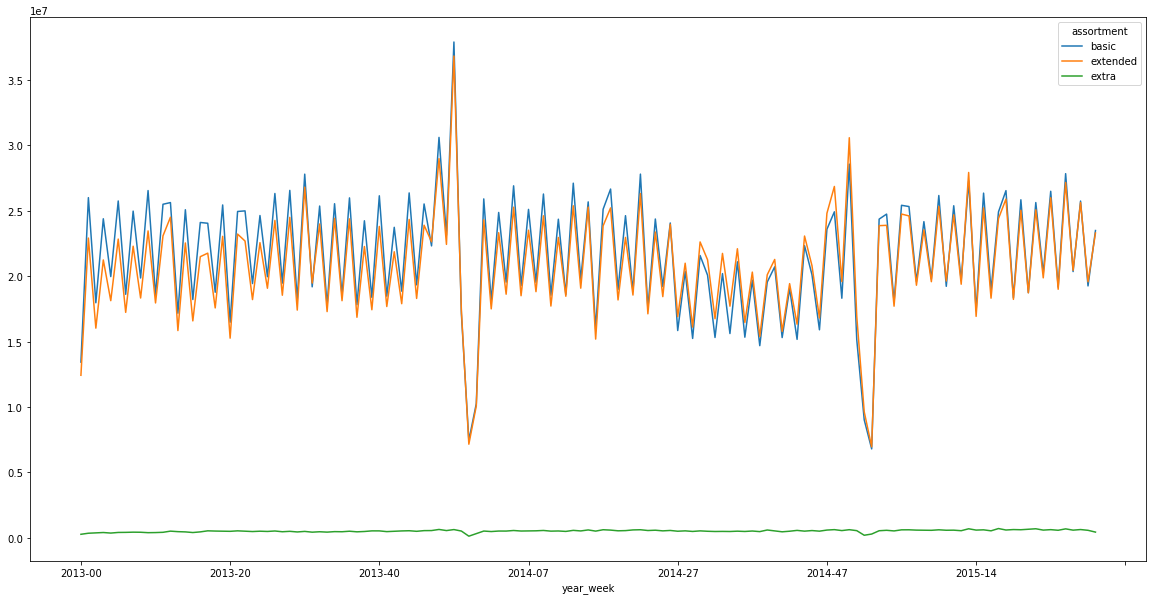

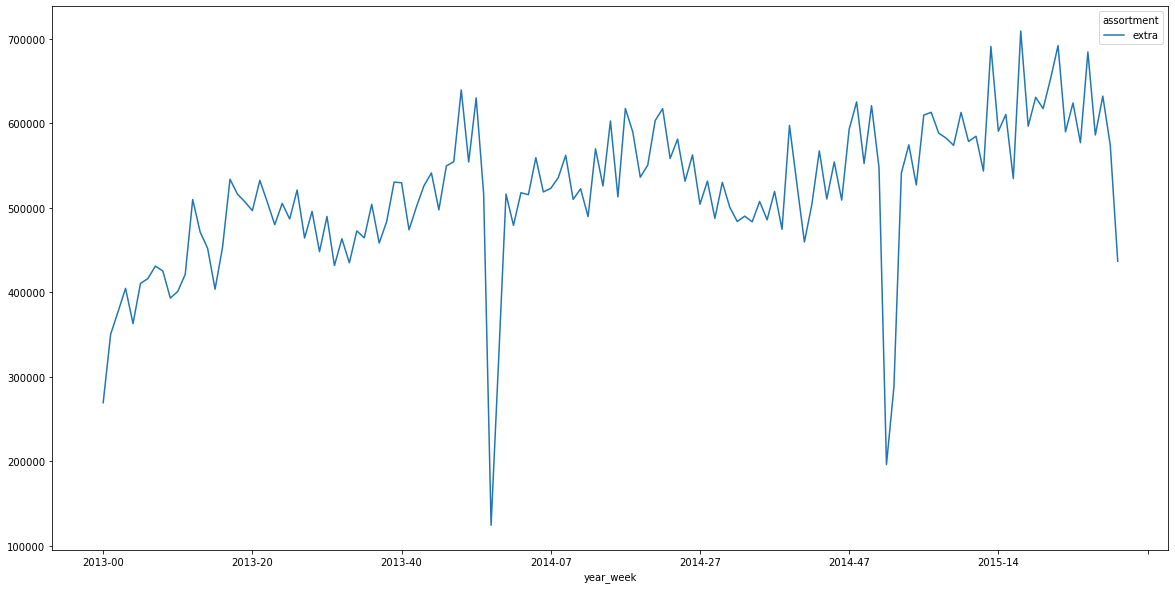

In [37]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
#df4[df4['assortment']=='basic']['sales'].sum()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### **H2** Lojas com competidores mais próximos deveriam vender menos
**FALSA** Lojas com competidores mais próximos vendem mais

<AxesSubplot:>

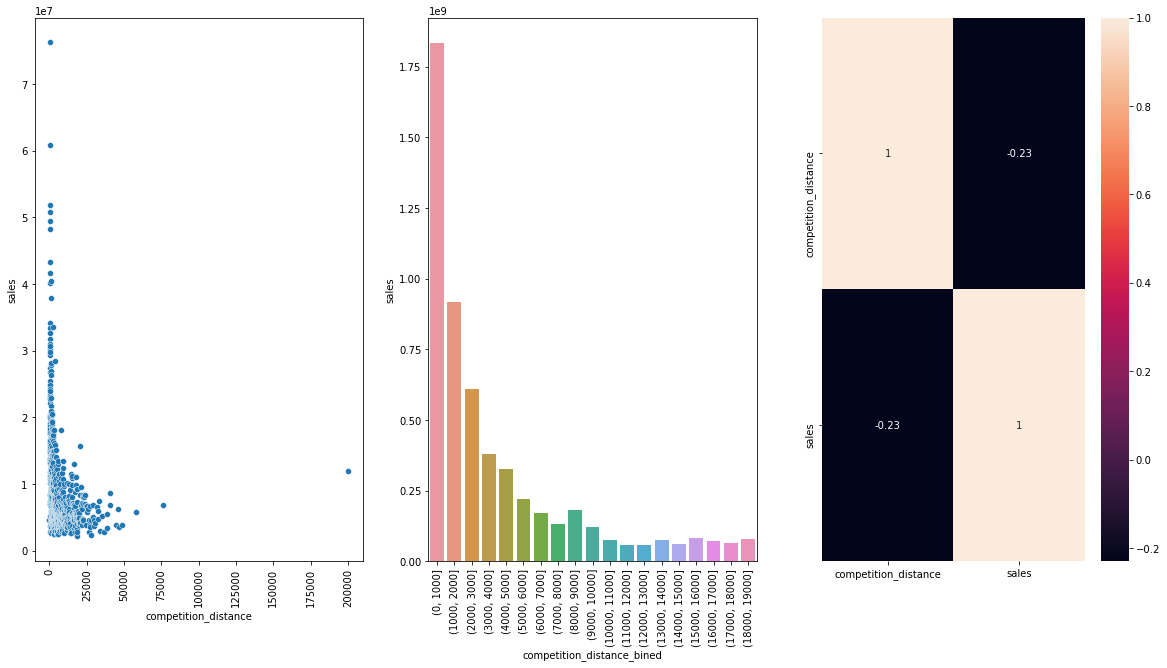

In [38]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

bins = list(np.arange(0,20000,1000))
aux1['competition_distance_bined'] = pd.cut(aux1['competition_distance'],bins)
aux2 = aux1[['competition_distance_bined', 'sales']].groupby('competition_distance_bined').sum().reset_index()
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.barplot(x='competition_distance_bined',y='sales',data=aux2)
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


### **H3** Lojas com competidores a mais tempo deveriam vender mais
**FALSE** Lojas com competidores a mais tempo vendem menos

<AxesSubplot:>

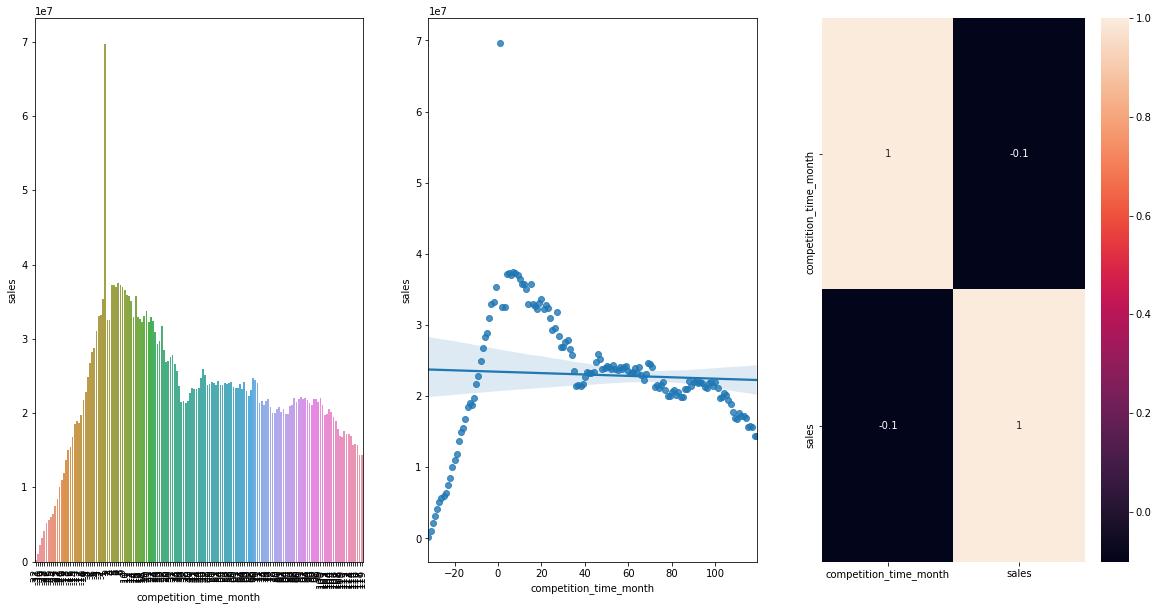

In [39]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

plt.subplot(1,3,1)
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


### **H4** Lojas com promoções ativas por mais tempo deveriam vender mais
**FALSA** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de tempo de promoção

<AxesSubplot:>

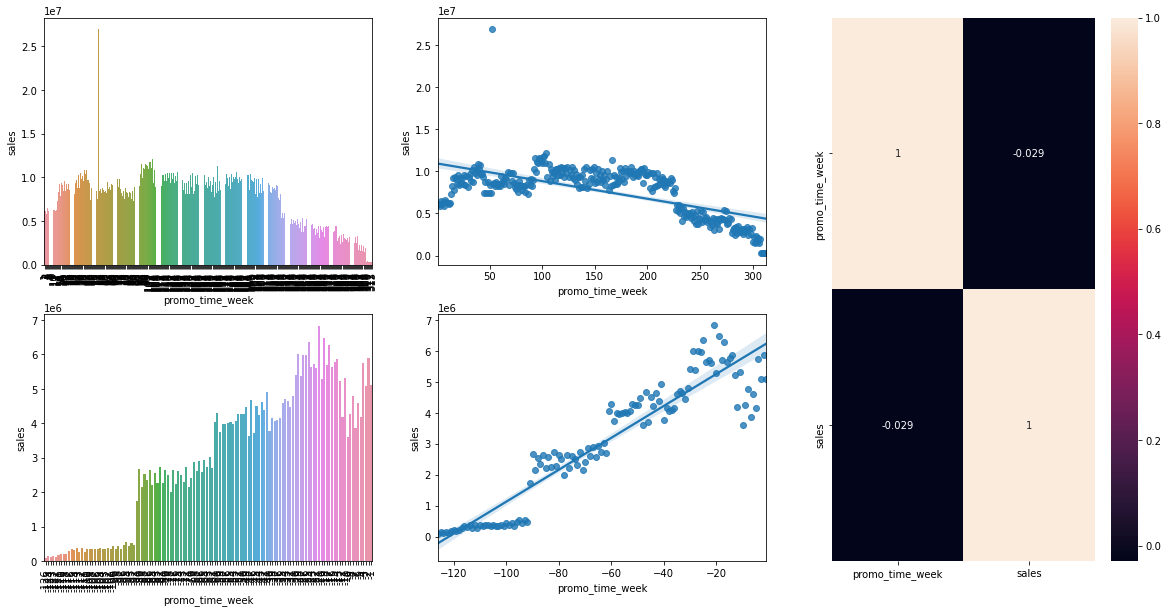

In [40]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
#sns.barplot(x='promo_time_week',y='sales',data=aux1)

grid = GridSpec.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']>0] # Promo extendido
sns.barplot(x='promo_time_week',y='sales',data=aux2)
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week',y='sales',data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']<0] # Promo regular
sns.barplot(x='promo_time_week',y='sales',data=aux3)
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week',y='sales',data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### **H5** Lojas com mais dias de promoção deveriam vender mais

### **H6** Lojas com mais promoções consecutivas deveriam vender mais
**FALSA** Lojas com mais promoções consecutivas vendem menos

In [41]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


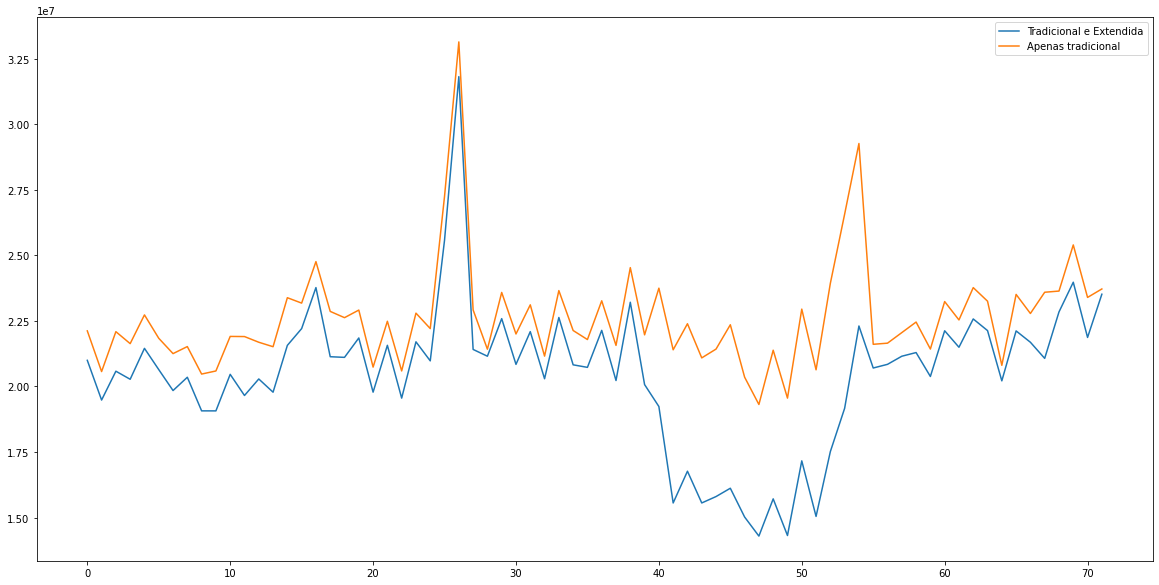

In [42]:
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e Extendida', 'Apenas tradicional'])

### **H7** Lojas abertas durante o feriado de Natal deveriam vender mais
**FALSA** Pois lojas abertas durante o feriado do Natal vendem menos

<AxesSubplot:xlabel='year', ylabel='sales'>

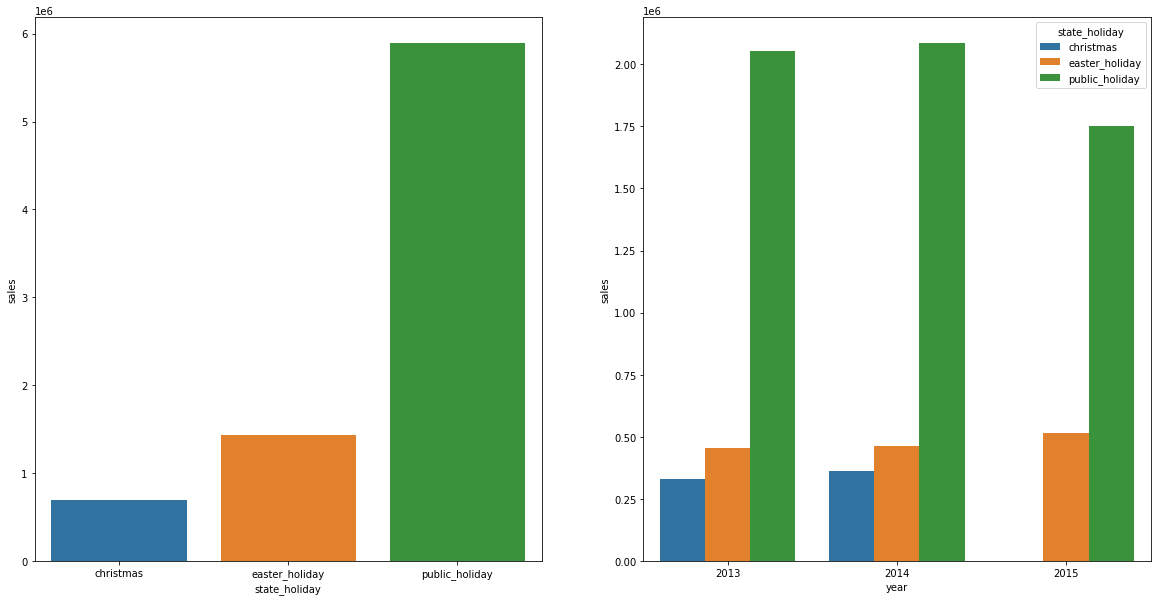

In [43]:
plt.subplot(1,2,1)
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales',hue='state_holiday',data=aux2)

### **H8** Lojas deveriam vender mais ao longo dos anos
**FALSA** Lojas vendem menos ao longo dos anos

<AxesSubplot:>

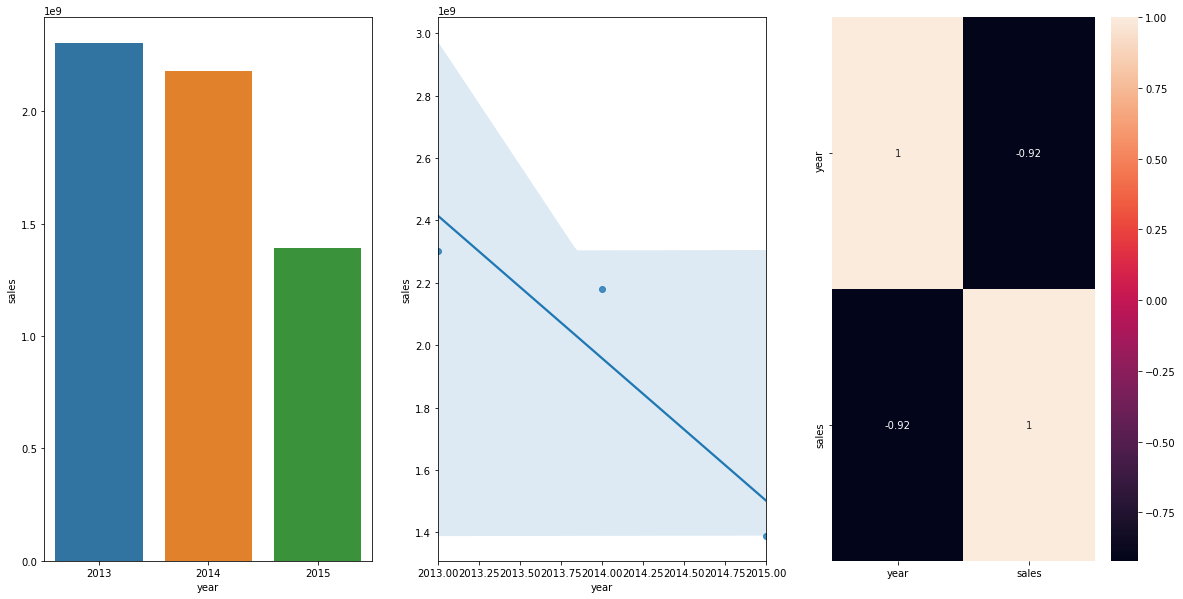

In [44]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### **H9** Lojas deveriam vender mais no segundo semestre do ano
**FALSA** Lojas vendem menos no segundo semestre do ano

<AxesSubplot:>

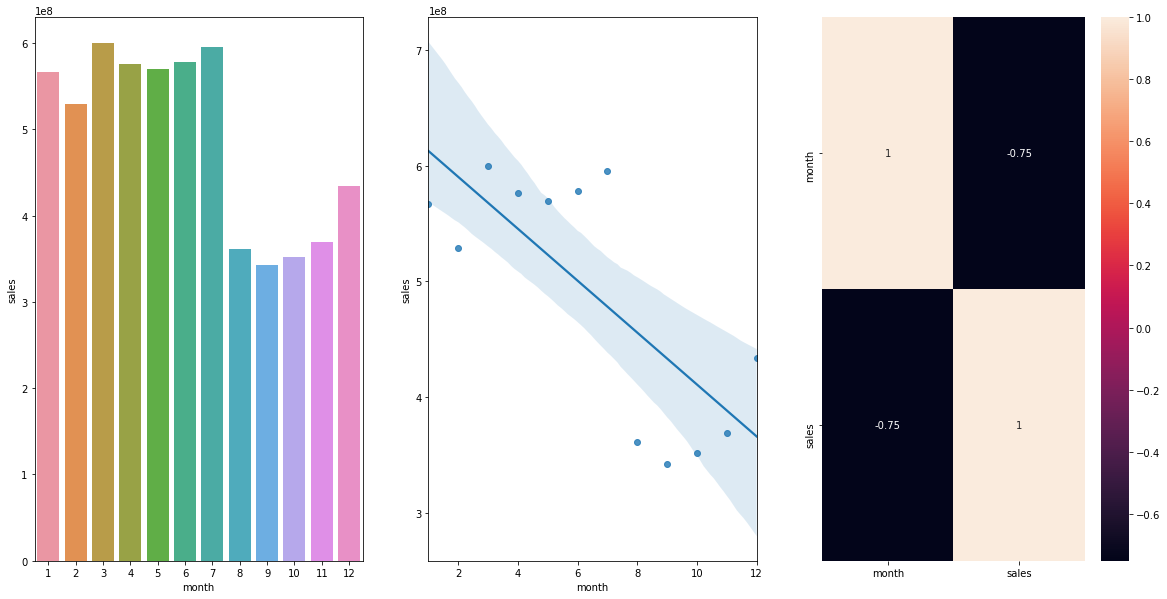

In [45]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### **H10** Lojas deveriam vender mais depois do dia 10 de cada mês
**VERDADEIRA** Lojas venem mais após o dia 10 de cada mês (porque a comparação é de vendas em 10 dias com vendas em 20 dias)

<AxesSubplot:xlabel='before_after_novo', ylabel='sales'>

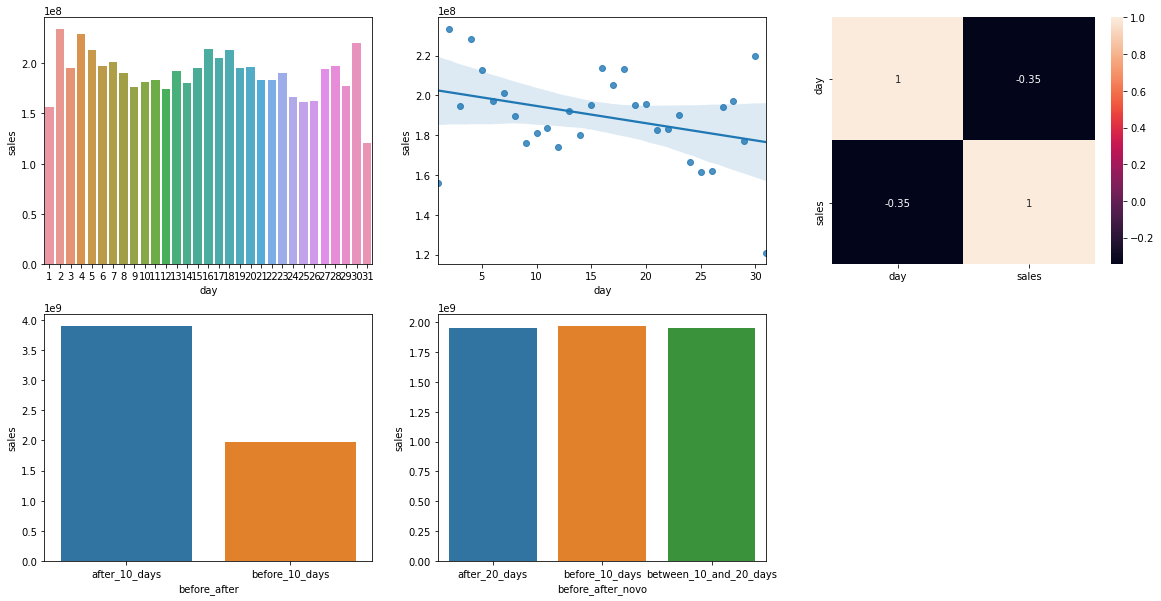

In [46]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,3,1)
sns.barplot(x='day',y='sales',data=aux1)

plt.subplot(2,3,2)
sns.regplot(x='day',y='sales',data=aux1)

plt.subplot(2,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<=10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,3,4)
sns.barplot(x='before_after',y='sales',data=aux2)

aux1['before_after_novo'] = aux1['day'].apply(lambda x: 'before_10_days' if x<=10 else 'after_20_days' if x>20 else 'between_10_and_20_days' )
aux3 = aux1[['before_after_novo','sales']].groupby('before_after_novo').sum().reset_index()

plt.subplot(2,3,5)
sns.barplot(x='before_after_novo',y='sales',data=aux3)

### **H11** Lojas deveriam vender menos aos finais de semana
**VERDADEIRA** Lojas vendem menos aos finais de semana

<AxesSubplot:>

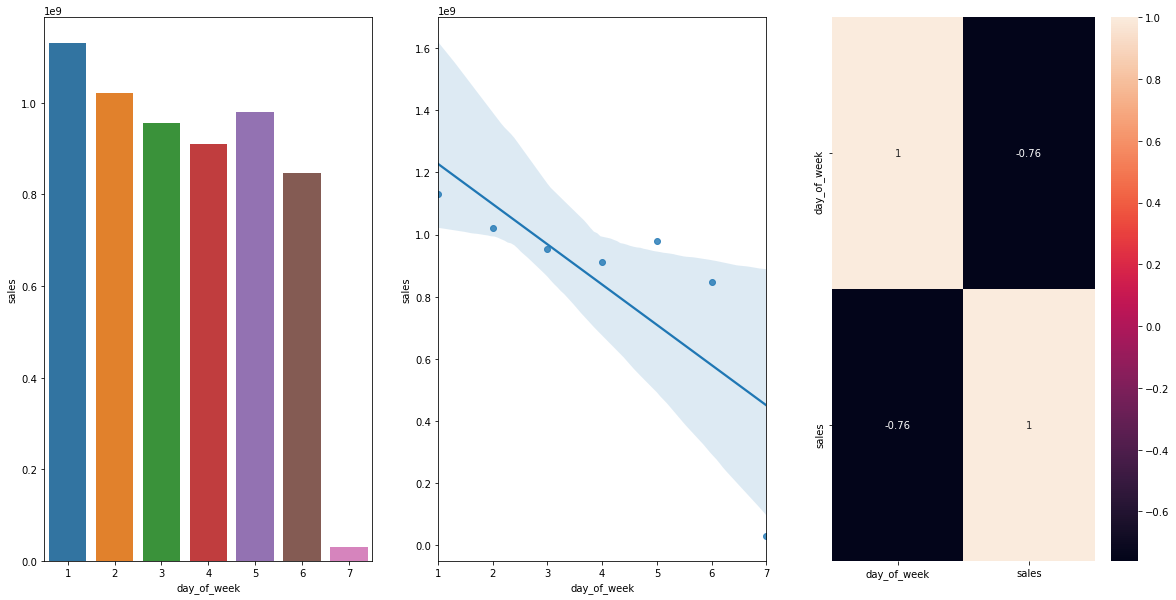

In [47]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### **H12** Lojas deveriam vender menos durante os feriados escolares
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto os meses de julho e agosto

<AxesSubplot:xlabel='month', ylabel='sales'>

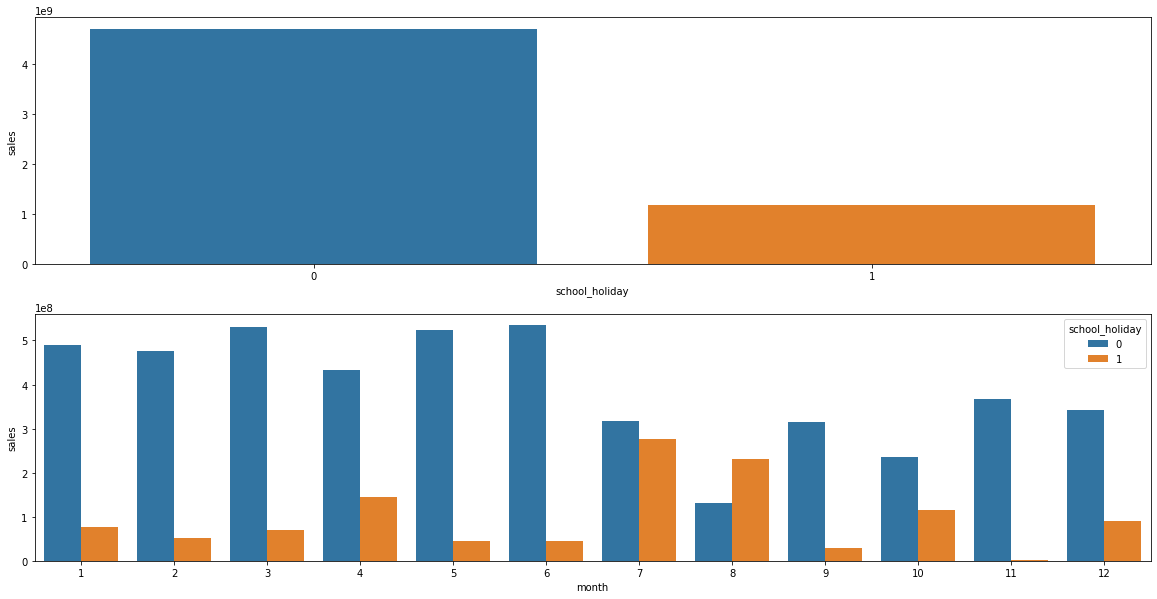

In [48]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday',y='sales',data=aux1)

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month',y='sales', hue='school_holiday', data=aux2)

### 4.2.1 Resumo das Hipóteses

In [49]:
tab = [['Hipótese', 'Conclusão', 'Relevância'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Média'],
       ['H3', 'Falsa', 'Média'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Média'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa'],   
      ]
print(tabulate(tab, headers='firstrow'))

Hipótese    Conclusão    Relevância
----------  -----------  ------------
H1          Falsa        Baixa
H2          Falsa        Média
H3          Falsa        Média
H4          Falsa        Baixa
H5          -            -
H6          Falsa        Baixa
H7          Falsa        Média
H8          Falsa        Alta
H9          Falsa        Alta
H10         Verdadeira   Alta
H11         Verdadeira   Alta
H12         Verdadeira   Baixa


## 4.3 Analise Multivariada

### 4.3.1 Numerical Attributes

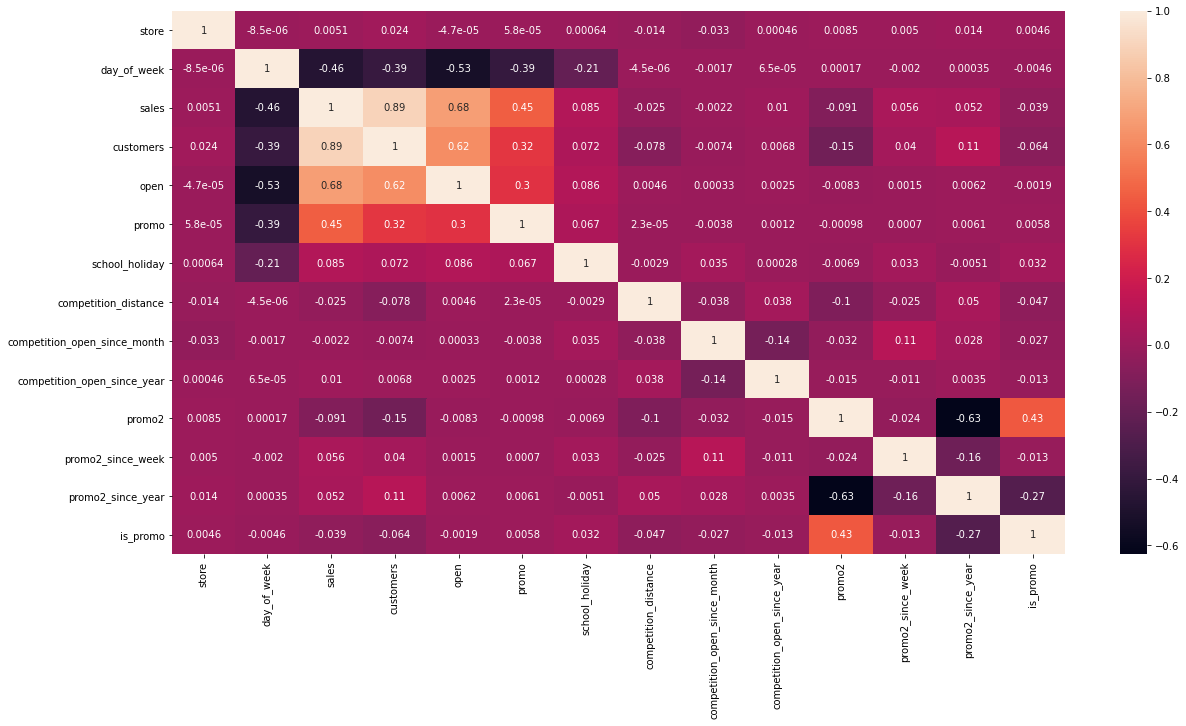

In [50]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.1 Categorical Attributes

In [51]:
# Only categorical data
a = df4.select_dtypes(include='object')

<AxesSubplot:>

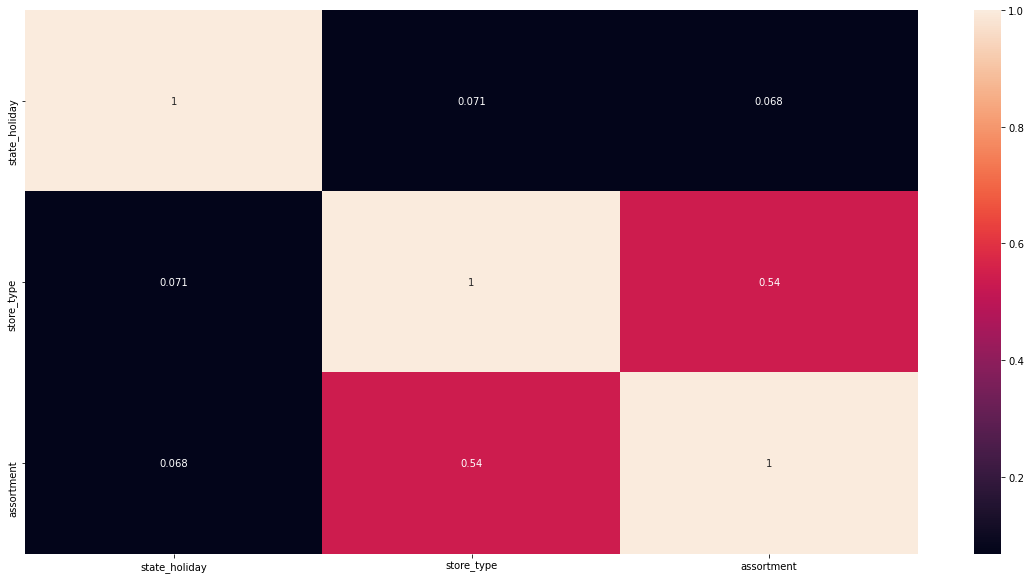

In [52]:
# Calculate Cramer v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame({'state_holiday' : [a1,a2,a3],
              'store_type' : [a4,a5,a6],
              'assortment' : [a7,a8,a9],})

d = d.set_index(d.columns)

sns.heatmap(d,annot=True)

# 5. DATA PREPARATION

In [53]:
df5 = df4.copy()

## 5.1 Normalização

### Analisando o item 4.1.2 Numerical Variable não foi identificada nenhuma distribuição normal, por isso não utilizamos a normalização

## 5.2 Rescaling

In [54]:
df5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_s

In [55]:
# Seleção das variáveis numéricas
a = df5.select_dtypes(include = ['int64', 'int32','float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


C:\Users\re91107z\AppData\Local\Continuum\anaconda3\envs\Repositorio\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\re91107z\AppData\Local\Continuum\anaconda3\envs\Repositorio\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\re91107z\AppData\Local\Continuum\anaconda3\envs\Repositorio\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other ar

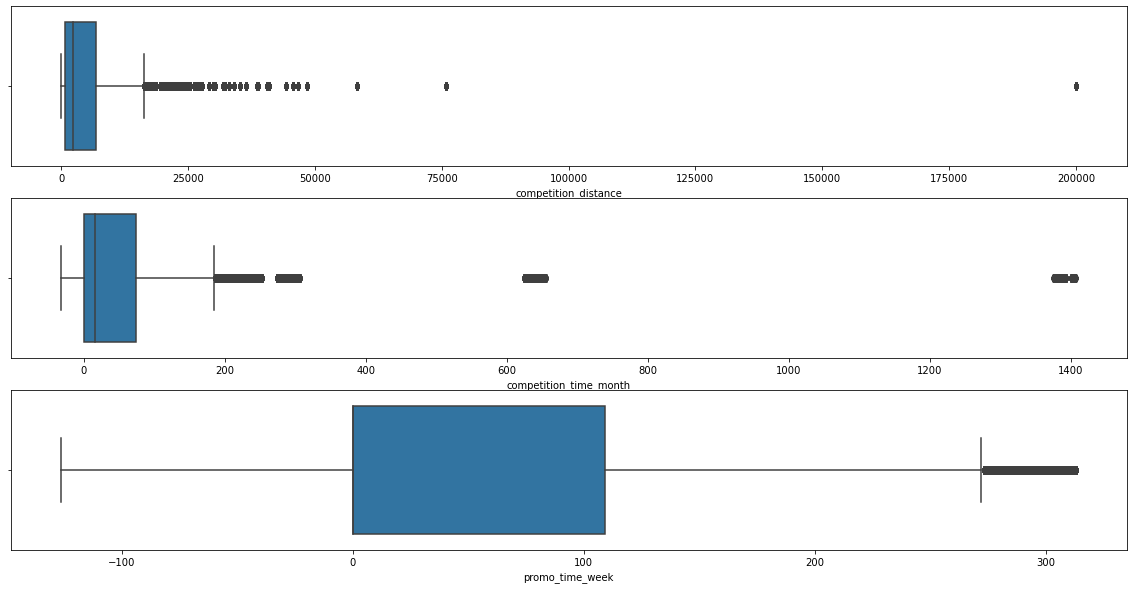

In [56]:
# Verificação das variáveis que possuem outliers relevantes
plt.subplot(3,1,1);
sns.boxplot(df5['competition_distance']);

plt.subplot(3,1,2);
sns.boxplot(df5['competition_time_month']);

plt.subplot(3,1,3);
sns.boxplot(df5['promo_time_week']);

In [57]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3 Transformação

### 5.3.1 Encoding

In [58]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns = ['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic' : 1, 'extra' : 2, 'extended' : 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [59]:
df5['sales'] = np.log1p(df5['sales'])

C:\Users\re91107z\AppData\Local\Continuum\anaconda3\envs\Repositorio\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

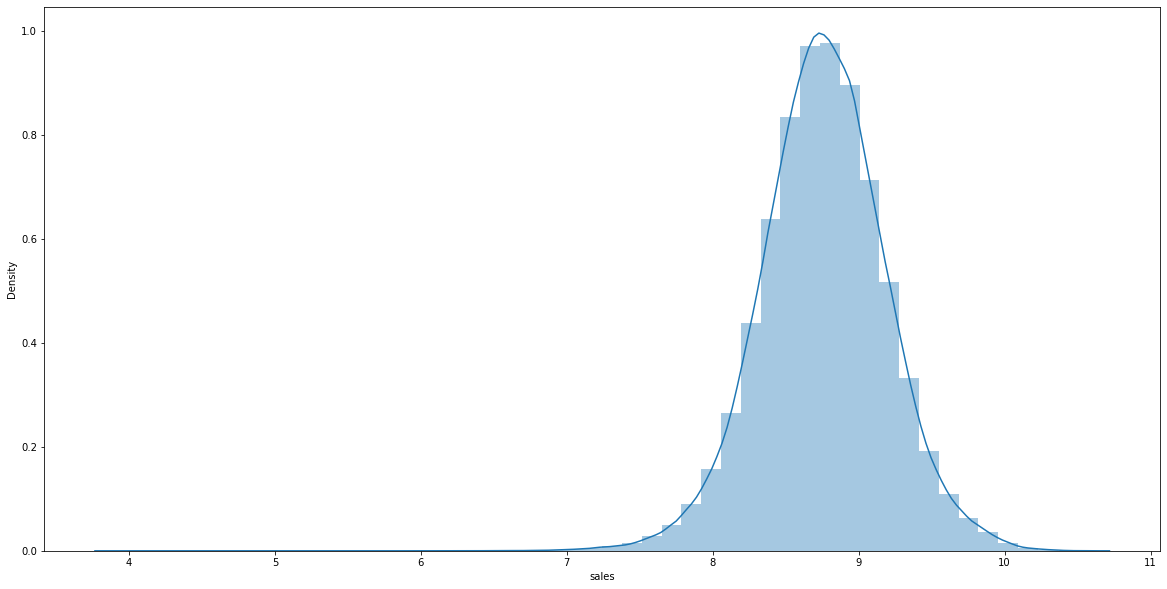

In [60]:
sns.distplot(df5['sales'])

### 5.3.3 Nature Transformation

In [61]:
# Variáveis ciclicas
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df5['week_of_yeary_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

# 6. FEATURE SELECTION

In [62]:
df6 = df5.copy()

In [63]:
# Deletar as variaveis replicadas na base de dados
cols_drop = ['week_of_year', 'year', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop(cols_drop,axis=1)

In [64]:
#df6[['store', 'date']].groupby('store').min().reset_index()
#df6[['store', 'date']].groupby('store').max().reset_index()

# Selecionando os dados das últimas 6 semanas para o conjunto de teste
df6[['store', 'date']].groupby('store').max().reset_index().date[0] - datetime.timedelta( 6*7 )

Timestamp('2015-06-19 00:00:00')

In [65]:
# Training dataset
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

# Test dataset
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

print('Training Min Date {}'.format(X_train['date'].min()))
print('Training Max Date {}'.format(X_train['date'].max()))

print('\nTest Min Date {}'.format(X_test['date'].min()))
print('Test Max Date {}'.format(X_test['date'].max()))

Training Min Date 2013-01-01 00:00:00
Training Max Date 2015-06-18 00:00:00

Test Min Date 2015-06-19 00:00:00
Test Max Date 2015-07-31 00:00:00


## 6.1 Split dataframe into training and test dataset

## 6.2 Boruta as feature selector

In [63]:
# Training and test dataset for Boruta
X_train_n = X_train.drop(['date','sales'], axis=1).values
Y_train_n = Y_train.values.ravel()

# define RandonForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n,Y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1 Best Features from Boruta

In [66]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop(['sales','date'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns,cols_selected_boruta))

NameError: name 'boruta' is not defined

## 6.3 Manual feature selector

In [104]:
cols_selected_boruta = [
'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month',
'promo_time_week',
'day_of_week_sin',
'day_of_week_cos',
'month_sin',
'month_cos',
'day_sin',
'day_cos',
'week_of_year_sin',
'week_of_yeary_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full =  cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7. MACHINE LEARNING MODELLING

In [136]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time series data preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [137]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

# prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1( Y_test ), np.expm1( yhat_baseline ))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [147]:
# Model
lr = LinearRegression().fit(x_train,Y_train)

# Prediction
yhat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1872.182412,0.300678,2646.650327


### 7.2.1 Linear Regression Model - Cross Validation

In [148]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2046.13+/-286.03,0.3+/-0.01,2918.62+/-425.91


## 7.3 Linear Regression Regularized Model - Lasso

In [71]:
# Model
lrr = Lasso( alpha=0.01 ).fit(x_train,Y_train)

# Prediction
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1904.350769,0.294618,2746.654079


### 7.3.1 Linear Regression Regularized Model - Lasso - Cross Validation

In [149]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2112.77+/-322.72,0.29+/-0.01,3053.82+/-471.0


## 7.4 Random Forest Regressor

In [73]:
# Model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit(x_train,Y_train)

# Prediction
yhat_rf = rf.predict(x_test)

# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,694.975525,0.102888,1021.256316


### 7.4.1 Random Forest Regressor - Cross Validation

In [152]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold_Number: 5

KFold_Number: 4

KFold_Number: 3

KFold_Number: 2

KFold_Number: 1


,Model name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,830.34+/-188.84,0.12+/-0.02,1243.56+/-278.57


## 7.5 XGBoost Regressor

In [77]:
# Model
model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
                              n_estimators = 100, 
                              eta = 0.01,
                              max_deph = 10,
                              subsample = 0.7,
                              colsample_bytee = 0.9).fit(x_train,Y_train)

# Prediction
yhat_xgb = model_xgb.predict(x_test)

# Performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1706.830457,0.255714,2455.052857


### 7.5.1 XGBoost Regressor - Cross Validation

In [153]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold_Number: 5

KFold_Number: 4

KFold_Number: 3

KFold_Number: 2

KFold_Number: 1


,Model name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1858.14+/-241.06,0.26+/-0.01,2670.77+/-338.11


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [80]:
modeling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modeling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,694.975525,0.102888,1021.256316
0,Average Model,1354.800353,0.455051,1835.135542
0,XGBoost Regressor,1706.830457,0.255714,2455.052857
0,Linear Regression,1872.182412,0.300678,2646.650327
0,Linear Regression - Lasso,1904.350769,0.294618,2746.654079


### 7.6.2 Real Performance - Cross Validation

In [154]:
modeling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modeling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,694.975525,0.102888,1021.256316
0,Average Model,1354.800353,0.455051,1835.135542
0,XGBoost Regressor,1706.830457,0.255714,2455.052857
0,Linear Regression,1872.182412,0.300678,2646.650327
0,Linear Regression - Lasso,1904.350769,0.294618,2746.654079
